In [3]:
CSV_PATH = '/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv'
IMG_PATH = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/'

In [4]:
!pip install torchsummary
!pip install fasttext

In [5]:
import fasttext
import fasttext.util
# fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('/kaggle/input/cc-en-300-bin/cc.en.300.bin')
ft.get_dimension()

300

In [6]:
import torch
import torch.nn as nn
from torchsummary import summary
import pandas as pd
from spacy.lang.en import English
import torchtext
from sklearn.model_selection import train_test_split
import tqdm
seed = 1234
import random
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [7]:
df = pd.read_csv(CSV_PATH, delimiter='|')
df.dropna(inplace=True)
df = df.iloc[:20000]
df.head(5)

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 0 to 20000
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_name       20000 non-null  object
 1    comment_number  20000 non-null  object
 2    comment         20000 non-null  object
dtypes: object(3)
memory usage: 625.0+ KB


In [9]:
train, remaining = train_test_split(df, test_size=0.2, random_state=42)

test, val = train_test_split(remaining, test_size=0.5, random_state=42)

print("Size of train set:", len(train))
print("Size of test set:", len(test))
print("Size of validation set:", len(val))

Size of train set: 16000
Size of test set: 2000
Size of validation set: 2000


In [10]:
def load_data(df):
    return df.to_dict(orient='list')

In [11]:
train_data = load_data(train[["image_name"," comment"]])
test_data = load_data(test[["image_name"," comment"]])
val_data = load_data(val[["image_name"," comment"]])

In [12]:
print(train_data['image_name'][0], train_data[' comment'][0])
print(test_data['image_name'][0], test_data[' comment'][0])
print(val_data['image_name'][0], val_data[' comment'][0])

1357724865.jpg  A man is standing in water near a waterfall .
112550433.jpg  A pretty girl dancing on a beach .
2196846255.jpg  A dog standing in the shallow part of the ocean while the waves splash around .


In [13]:
tokenizer = English()

In [14]:
def tokenize_sample(comment, tokenizer, max_length, sos_token, eos_token, lower):
    tokens = [token.text for token in tokenizer.tokenizer(comment.strip())][:max_length]
    if lower:
        tokens = [token.lower() for token in tokens]
    tokens = [sos_token] + tokens + [eos_token]
    return tokens

In [15]:
sos_token = "<sos>"
eos_token = "<eos>"
max_length = 200
lower = True
train_data["tokens"] = [tokenize_sample(cm,tokenizer,max_length,sos_token,eos_token,lower) for cm in train_data[" comment"]]
val_data["tokens"] = [tokenize_sample(cm,tokenizer,max_length,sos_token,eos_token,lower) for cm in val_data[" comment"]]
test_data["tokens"] = [tokenize_sample(cm,tokenizer,max_length,sos_token,eos_token,lower) for cm in test_data[" comment"]]

In [16]:
train_data[" comment"][0],train_data["tokens"][0], 

(' A man is standing in water near a waterfall .',
 ['<sos>',
  'a',
  'man',
  'is',
  'standing',
  'in',
  'water',
  'near',
  'a',
  'waterfall',
  '.',
  '<eos>'])

In [17]:
def yield_token(data, key):
    for token in data[key]:
        yield token

In [18]:
import torchtext.vocab


min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"
special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token
]
vocab = torchtext.vocab.build_vocab_from_iterator(
    yield_token(train_data,"tokens"),
    min_freq=min_freq,
    specials=special_tokens
)

In [19]:
vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', 'a', '.', 'in', 'the', 'on', 'man']

In [20]:
len(vocab)

4398

In [21]:
unk_index = vocab[unk_token]
pad_index = vocab[pad_token]
unk_index, pad_index

(0, 1)

In [22]:
vocab.set_default_index(unk_index)

In [23]:
def token2ids(tokens, vocab):
    ids = vocab.lookup_indices(tokens)
    return ids

In [24]:
train_data["ids"] = [token2ids(t,vocab) for t in train_data["tokens"]]
val_data["ids"] = [token2ids(t,vocab) for t in val_data["tokens"]]
test_data["ids"] = [token2ids(t,vocab) for t in test_data["tokens"]]

In [25]:
train_data[" comment"][0],train_data["tokens"][0],train_data["ids"][0]

(' A man is standing in water near a waterfall .',
 ['<sos>',
  'a',
  'man',
  'is',
  'standing',
  'in',
  'water',
  'near',
  'a',
  'waterfall',
  '.',
  '<eos>'],
 [2, 4, 9, 11, 34, 6, 45, 75, 4, 1124, 5, 3])

In [26]:
# def load_pretrained_embeddings(special_tokens, vocab, file_name, dims):
#     embeddings = torch.zeros(len(vocab),dims)
#     for i in range(len(vocab)):
#         key = vocab.get_itos()[i]
#         if key in special_tokens:
#             embeddings[i] = torch.zeros(dims)
#         else:
#             !cat $file_name | grep $key | head -n 1 | cut -d " " -f 2-  > temp.txt
#             with open('/kaggle/working/temp.txt','r') as file:
#                 content = file.read()
#                 if content:
#                     embeddings[i] = torch.from_numpy(np.array(content.split(" "), dtype=float))
#                 else:
#                     embeddings[i] = torch.zeros(dims)
#     !rm "/kaggle/working/temp.txt"
#     return embeddings

In [27]:
# def load_pretrained_embeddings(vocab, file_name, dims):
#     embeddings = torch.zeros(len(vocab),dims)
#     with open(file_name, 'r') as f:
#         for line in f.readlines():
#             splited_line = line.split(" ")
#             word = splited_line[0]
#             vec = splited_line[1:]
#             if word in vocab.get_stoi():
#                 assert len(vec) == 300
#                 embeddings[vocab.get_stoi()[word]] = torch.from_numpy(np.array(vec,dtype=float))
#     return embeddings

In [28]:
def load_pretrained_embeddings(ft_model, vocab, special_tokens, dims):
    embeddings = torch.zeros(len(vocab),dims)
    for i in range(len(vocab)):
        key = vocab.get_itos()[i]
        if key in special_tokens:
            embeddings[i] = torch.zeros(dims)
        else:
            embeddings[i] = torch.from_numpy(ft_model.get_word_vector(key))
    return embeddings

In [29]:
embeddings = load_pretrained_embeddings(ft,vocab,special_tokens,300)

In [30]:
embeddings.shape

torch.Size([4398, 300])

In [31]:
import torch.utils
import torch.utils.data
from PIL import Image

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform, path_prefix):
        self.img_paths = data["image_name"]
        self.ids = data["ids"]
        self.transform = transform
        self.path_prefix = path_prefix

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        image = Image.open(self.path_prefix+self.img_paths[index])
        torch_img = self.transform(image)
        return torch_img, torch.tensor(self.ids[index],dtype=torch.int64)

In [32]:
from torchvision.transforms import Compose, transforms

In [33]:
transform = Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [34]:
train_dataset = CustomDataset(train_data, transform, IMG_PATH)
val_dataset = CustomDataset(val_data, transform, IMG_PATH)
test_dataset = CustomDataset(test_data, transform, IMG_PATH)

In [35]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_img = torch.stack([b[0] for b in batch])
        batch_ids = [b[1] for b in batch]
        batch_ids = torch.nn.utils.rnn.pad_sequence(batch_ids,batch_first=True,padding_value=pad_index)
        return batch_img, batch_ids
    return collate_fn

In [36]:
def get_dataloader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader =  torch.utils.data.DataLoader(dataset,batch_size,shuffle,collate_fn=collate_fn)
    return data_loader

In [37]:
batch_size = 256
shuffle = True
train_dataloader = get_dataloader(train_dataset,batch_size,pad_index,shuffle)
val_dataloader = get_dataloader(val_dataset,batch_size,pad_index)
test_dataloader = get_dataloader(test_dataset,batch_size,pad_index)

In [38]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels,
                               out_channels,
                               kernel_size=3,
                               stride=stride,
                               padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,
                               out_channels,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels,
                          out_channels,
                          kernel_size=1,
                          stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)
        return x

In [39]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        
    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)
        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride)
            blocks.append(block)
        block_sequential = nn.Sequential(*blocks)
        return block_sequential
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        return x

In [40]:
class Encoder(torch.nn.Module):
    def __init__(self, resnet, hidden_dim, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout)
        if hidden_dim != 512:
            self.model = nn.Sequential(resnet, nn.Linear(512,hidden_dim))
        else:
            self.model = resnet
        
    
    def forward(self,x):
        return self.dropout(self.model(x))

In [41]:
class Decoder(torch.nn.Module):
    def __init__(self, hidden_dim, embedding_dim, vocab_size, padding_idx, embeddings, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = torch.nn.Embedding.from_pretrained(embeddings)
        self.rnn = torch.nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim,vocab_size)
        self.dropout = torch.nn.Dropout(dropout)
    
    def forward(self, input, hidden):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded,(hidden))
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden

In [42]:
class Img2Seq(torch.nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert(self.encoder.hidden_dim == self.decoder.hidden_dim), "Hidden dimensions of encoder and decoder must be equal"
    
    def forward(self, batch_imgs, batch_ids, teacher_forcing_ratio):
        batch_size = batch_imgs.shape[0]
        vocab_size = self.decoder.vocab_size
        seq_length = batch_ids.shape[1]
        outputs = torch.zeros(batch_size,seq_length,vocab_size).to(self.device)
        hidden = self.encoder(batch_imgs).unsqueeze(0) # D * numlayer x batch x hidden_dim
        inputs = batch_ids[:,0]
        for i in range(1, seq_length):
            output, hidden = self.decoder(inputs,hidden)
            outputs[:,i,:] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            inputs = batch_ids[:,i] if teacher_force else top1
        return outputs

In [43]:
vocab_size = len(vocab)
hidden_dim = 512
embedding_dim = 300
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2,2,2,2],
)
encoder = Encoder(resnet,hidden_dim,dropout).to(device)
decoder = Decoder(hidden_dim,embedding_dim,vocab_size,pad_index,embeddings,dropout).to(device)
img2seq = Img2Seq(encoder,decoder,device).to(device)

In [44]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {count_parameters(img2seq):,} trainable parameters")

The model has 14,201,006 trainable parameters


In [45]:
print(img2seq)

Img2Seq(
  (encoder): Encoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (conv2): Sequential(
        (0): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (downsample): Sequential()
          (relu): ReLU()
        )
        (1): ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), paddi

In [46]:
optimizer = torch.optim.Adam(img2seq.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_index)

In [47]:
def train_fn(model, data_loader, optimizer, criterion, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0
    for batch_imgs, batch_ids in data_loader:
        batch_imgs, batch_ids = batch_imgs.to(device), batch_ids.to(device)
        optimizer.zero_grad()
        output = model(batch_imgs,batch_ids,teacher_forcing_ratio)
        output_dim = output.shape[-1]
        output = output[:,1:,].reshape(-1,output_dim)
        target = batch_ids[:,1:].reshape(-1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [48]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch_imgs, batch_ids in data_loader:
            batch_imgs, batch_ids = batch_imgs.to(device), batch_ids.to(device)
            output = model(batch_imgs,batch_ids,0)
            output_dim = output.shape[-1]
            output = output[:,1:,].reshape(-1,output_dim)
            target = batch_ids[:,1:].reshape(-1)
            loss = criterion(output, target)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [49]:
n_epochs = 100
teacher_forcing_ratio = 0.6
best_valid_loss = float("inf")
train_losses = []
val_losses = []
for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        img2seq,
        train_dataloader,
        optimizer,
        criterion,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        img2seq, 
        val_dataloader, 
        criterion, 
        device)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(img2seq.state_dict(), "model.pt")
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

  1%|          | 1/100 [02:49<4:39:17, 169.27s/it]

	Train Loss:   5.424 | Train PPL: 226.732
	Valid Loss:   4.989 | Valid PPL: 146.818


  2%|▏         | 2/100 [05:18<4:17:38, 157.74s/it]

	Train Loss:   4.889 | Train PPL: 132.848
	Valid Loss:   4.981 | Valid PPL: 145.611


  3%|▎         | 3/100 [07:51<4:10:57, 155.23s/it]

	Train Loss:   4.767 | Train PPL: 117.564
	Valid Loss:   5.032 | Valid PPL: 153.297


  4%|▍         | 4/100 [10:20<4:04:47, 152.99s/it]

	Train Loss:   4.671 | Train PPL: 106.803
	Valid Loss:   5.058 | Valid PPL: 157.288


  5%|▌         | 5/100 [12:50<4:00:30, 151.90s/it]

	Train Loss:   4.607 | Train PPL: 100.209
	Valid Loss:   5.061 | Valid PPL: 157.752


  6%|▌         | 6/100 [15:18<3:55:48, 150.52s/it]

	Train Loss:   4.521 | Train PPL:  91.902
	Valid Loss:   5.076 | Valid PPL: 160.162


  7%|▋         | 7/100 [17:50<3:53:54, 150.91s/it]

	Train Loss:   4.433 | Train PPL:  84.176
	Valid Loss:   5.141 | Valid PPL: 170.903


  8%|▊         | 8/100 [20:20<3:51:05, 150.72s/it]

	Train Loss:   4.385 | Train PPL:  80.224
	Valid Loss:   4.994 | Valid PPL: 147.463


  9%|▉         | 9/100 [22:52<3:49:03, 151.03s/it]

	Train Loss:   4.290 | Train PPL:  72.959
	Valid Loss:   5.079 | Valid PPL: 160.667


 10%|█         | 10/100 [25:23<3:46:50, 151.23s/it]

	Train Loss:   4.227 | Train PPL:  68.489
	Valid Loss:   5.114 | Valid PPL: 166.304


 11%|█         | 11/100 [27:54<3:43:53, 150.94s/it]

	Train Loss:   4.164 | Train PPL:  64.318
	Valid Loss:   4.987 | Valid PPL: 146.567


 12%|█▏        | 12/100 [30:24<3:40:51, 150.59s/it]

	Train Loss:   4.124 | Train PPL:  61.810
	Valid Loss:   5.071 | Valid PPL: 159.315


 13%|█▎        | 13/100 [32:55<3:38:32, 150.72s/it]

	Train Loss:   4.072 | Train PPL:  58.699
	Valid Loss:   5.035 | Valid PPL: 153.757


 14%|█▍        | 14/100 [35:24<3:35:33, 150.39s/it]

	Train Loss:   4.040 | Train PPL:  56.803
	Valid Loss:   4.956 | Valid PPL: 142.013


 15%|█▌        | 15/100 [37:55<3:33:02, 150.38s/it]

	Train Loss:   3.969 | Train PPL:  52.933
	Valid Loss:   4.987 | Valid PPL: 146.506


 16%|█▌        | 16/100 [40:23<3:29:51, 149.90s/it]

	Train Loss:   3.963 | Train PPL:  52.605
	Valid Loss:   4.969 | Valid PPL: 143.877


 17%|█▋        | 17/100 [42:52<3:27:02, 149.67s/it]

	Train Loss:   3.918 | Train PPL:  50.318
	Valid Loss:   4.943 | Valid PPL: 140.182


 18%|█▊        | 18/100 [45:21<3:24:10, 149.39s/it]

	Train Loss:   3.857 | Train PPL:  47.325
	Valid Loss:   5.024 | Valid PPL: 152.068


 19%|█▉        | 19/100 [47:51<3:21:41, 149.40s/it]

	Train Loss:   3.837 | Train PPL:  46.375
	Valid Loss:   4.978 | Valid PPL: 145.208


 20%|██        | 20/100 [50:19<3:18:49, 149.12s/it]

	Train Loss:   3.807 | Train PPL:  45.032
	Valid Loss:   5.082 | Valid PPL: 161.098


 21%|██        | 21/100 [52:49<3:16:32, 149.27s/it]

	Train Loss:   3.734 | Train PPL:  41.851
	Valid Loss:   4.988 | Valid PPL: 146.681


 22%|██▏       | 22/100 [55:18<3:14:08, 149.34s/it]

	Train Loss:   3.758 | Train PPL:  42.867
	Valid Loss:   4.972 | Valid PPL: 144.283


 23%|██▎       | 23/100 [57:48<3:11:43, 149.39s/it]

	Train Loss:   3.707 | Train PPL:  40.727
	Valid Loss:   4.991 | Valid PPL: 147.068


 24%|██▍       | 24/100 [1:00:17<3:09:20, 149.48s/it]

	Train Loss:   3.676 | Train PPL:  39.473
	Valid Loss:   4.987 | Valid PPL: 146.438


 25%|██▌       | 25/100 [1:02:46<3:06:29, 149.20s/it]

	Train Loss:   3.641 | Train PPL:  38.123
	Valid Loss:   4.964 | Valid PPL: 143.154


 26%|██▌       | 26/100 [1:05:14<3:03:45, 148.99s/it]

	Train Loss:   3.618 | Train PPL:  37.250
	Valid Loss:   5.005 | Valid PPL: 149.191


 27%|██▋       | 27/100 [1:07:45<3:01:40, 149.32s/it]

	Train Loss:   3.566 | Train PPL:  35.369
	Valid Loss:   5.040 | Valid PPL: 154.516


 28%|██▊       | 28/100 [1:10:16<2:59:48, 149.84s/it]

	Train Loss:   3.582 | Train PPL:  35.961
	Valid Loss:   5.011 | Valid PPL: 150.090


 29%|██▉       | 29/100 [1:12:48<2:58:07, 150.53s/it]

	Train Loss:   3.531 | Train PPL:  34.145
	Valid Loss:   5.075 | Valid PPL: 160.038


 30%|███       | 30/100 [1:15:20<2:56:18, 151.12s/it]

	Train Loss:   3.509 | Train PPL:  33.401
	Valid Loss:   5.032 | Valid PPL: 153.272


 31%|███       | 31/100 [1:17:51<2:53:36, 150.97s/it]

	Train Loss:   3.478 | Train PPL:  32.383
	Valid Loss:   5.059 | Valid PPL: 157.473


 32%|███▏      | 32/100 [1:20:22<2:51:10, 151.03s/it]

	Train Loss:   3.451 | Train PPL:  31.532
	Valid Loss:   4.980 | Valid PPL: 145.472


 33%|███▎      | 33/100 [1:22:53<2:48:28, 150.88s/it]

	Train Loss:   3.443 | Train PPL:  31.280
	Valid Loss:   4.989 | Valid PPL: 146.809


 34%|███▍      | 34/100 [1:25:25<2:46:24, 151.27s/it]

	Train Loss:   3.429 | Train PPL:  30.854
	Valid Loss:   5.009 | Valid PPL: 149.712


 35%|███▌      | 35/100 [1:27:57<2:44:06, 151.48s/it]

	Train Loss:   3.408 | Train PPL:  30.205
	Valid Loss:   5.021 | Valid PPL: 151.579


 36%|███▌      | 36/100 [1:30:26<2:40:48, 150.76s/it]

	Train Loss:   3.365 | Train PPL:  28.921
	Valid Loss:   5.107 | Valid PPL: 165.158


 37%|███▋      | 37/100 [1:32:56<2:38:10, 150.65s/it]

	Train Loss:   3.319 | Train PPL:  27.646
	Valid Loss:   5.103 | Valid PPL: 164.519


 38%|███▊      | 38/100 [1:35:28<2:35:57, 150.92s/it]

	Train Loss:   3.347 | Train PPL:  28.406
	Valid Loss:   5.041 | Valid PPL: 154.636


 39%|███▉      | 39/100 [1:37:59<2:33:24, 150.89s/it]

	Train Loss:   3.259 | Train PPL:  26.023
	Valid Loss:   5.122 | Valid PPL: 167.619


 40%|████      | 40/100 [1:40:30<2:31:12, 151.21s/it]

	Train Loss:   3.257 | Train PPL:  25.983
	Valid Loss:   5.145 | Valid PPL: 171.551


 41%|████      | 41/100 [1:43:01<2:28:32, 151.05s/it]

	Train Loss:   3.327 | Train PPL:  27.847
	Valid Loss:   4.995 | Valid PPL: 147.663


 42%|████▏     | 42/100 [1:45:32<2:25:53, 150.92s/it]

	Train Loss:   3.276 | Train PPL:  26.468
	Valid Loss:   5.083 | Valid PPL: 161.315


 43%|████▎     | 43/100 [1:48:04<2:23:38, 151.19s/it]

	Train Loss:   3.208 | Train PPL:  24.736
	Valid Loss:   5.073 | Valid PPL: 159.582


 44%|████▍     | 44/100 [1:50:35<2:21:14, 151.34s/it]

	Train Loss:   3.205 | Train PPL:  24.647
	Valid Loss:   5.041 | Valid PPL: 154.654


 45%|████▌     | 45/100 [1:53:05<2:18:20, 150.92s/it]

	Train Loss:   3.195 | Train PPL:  24.404
	Valid Loss:   5.148 | Valid PPL: 172.165


 46%|████▌     | 46/100 [1:55:38<2:16:11, 151.33s/it]

	Train Loss:   3.136 | Train PPL:  23.001
	Valid Loss:   5.140 | Valid PPL: 170.778


 47%|████▋     | 47/100 [1:58:09<2:13:41, 151.35s/it]

	Train Loss:   3.161 | Train PPL:  23.587
	Valid Loss:   5.097 | Valid PPL: 163.485


 48%|████▊     | 48/100 [2:00:39<2:10:53, 151.04s/it]

	Train Loss:   3.156 | Train PPL:  23.485
	Valid Loss:   5.104 | Valid PPL: 164.660


 49%|████▉     | 49/100 [2:03:08<2:07:55, 150.49s/it]

	Train Loss:   3.123 | Train PPL:  22.717
	Valid Loss:   5.125 | Valid PPL: 168.174


 50%|█████     | 50/100 [2:05:38<2:05:13, 150.27s/it]

	Train Loss:   3.090 | Train PPL:  21.973
	Valid Loss:   5.187 | Valid PPL: 178.942


 51%|█████     | 51/100 [2:08:08<2:02:33, 150.07s/it]

	Train Loss:   3.089 | Train PPL:  21.957
	Valid Loss:   5.186 | Valid PPL: 178.757


 52%|█████▏    | 52/100 [2:10:38<2:00:09, 150.21s/it]

	Train Loss:   3.074 | Train PPL:  21.621
	Valid Loss:   5.220 | Valid PPL: 184.864


 53%|█████▎    | 53/100 [2:13:08<1:57:26, 149.92s/it]

	Train Loss:   3.066 | Train PPL:  21.456
	Valid Loss:   5.193 | Valid PPL: 180.004


 54%|█████▍    | 54/100 [2:15:40<1:55:30, 150.67s/it]

	Train Loss:   3.010 | Train PPL:  20.281
	Valid Loss:   5.190 | Valid PPL: 179.426


 55%|█████▌    | 55/100 [2:18:10<1:52:51, 150.48s/it]

	Train Loss:   3.039 | Train PPL:  20.890
	Valid Loss:   5.191 | Valid PPL: 179.631


 56%|█████▌    | 56/100 [2:20:42<1:50:46, 151.05s/it]

	Train Loss:   2.999 | Train PPL:  20.064
	Valid Loss:   5.165 | Valid PPL: 174.971


 57%|█████▋    | 57/100 [2:23:14<1:48:21, 151.19s/it]

	Train Loss:   2.961 | Train PPL:  19.309
	Valid Loss:   5.224 | Valid PPL: 185.659


 58%|█████▊    | 58/100 [2:25:47<1:46:12, 151.72s/it]

	Train Loss:   3.023 | Train PPL:  20.546
	Valid Loss:   5.214 | Valid PPL: 183.863


 59%|█████▉    | 59/100 [2:28:19<1:43:41, 151.74s/it]

	Train Loss:   2.953 | Train PPL:  19.166
	Valid Loss:   5.235 | Valid PPL: 187.760


 60%|██████    | 60/100 [2:30:50<1:41:01, 151.55s/it]

	Train Loss:   2.939 | Train PPL:  18.897
	Valid Loss:   5.208 | Valid PPL: 182.703


 61%|██████    | 61/100 [2:33:25<1:39:12, 152.63s/it]

	Train Loss:   2.930 | Train PPL:  18.722
	Valid Loss:   5.256 | Valid PPL: 191.657


 62%|██████▏   | 62/100 [2:36:01<1:37:18, 153.66s/it]

	Train Loss:   2.886 | Train PPL:  17.927
	Valid Loss:   5.246 | Valid PPL: 189.764


 63%|██████▎   | 63/100 [2:38:38<1:35:24, 154.73s/it]

	Train Loss:   2.932 | Train PPL:  18.774
	Valid Loss:   5.249 | Valid PPL: 190.348


 64%|██████▍   | 64/100 [2:41:14<1:33:02, 155.08s/it]

	Train Loss:   2.930 | Train PPL:  18.727
	Valid Loss:   5.234 | Valid PPL: 187.555


 65%|██████▌   | 65/100 [2:43:49<1:30:26, 155.03s/it]

	Train Loss:   2.886 | Train PPL:  17.915
	Valid Loss:   5.292 | Valid PPL: 198.809


 66%|██████▌   | 66/100 [2:46:23<1:27:36, 154.60s/it]

	Train Loss:   2.893 | Train PPL:  18.043
	Valid Loss:   5.257 | Valid PPL: 191.975


 67%|██████▋   | 67/100 [2:48:55<1:24:41, 153.97s/it]

	Train Loss:   2.849 | Train PPL:  17.278
	Valid Loss:   5.273 | Valid PPL: 194.998


 68%|██████▊   | 68/100 [2:51:27<1:21:48, 153.39s/it]

	Train Loss:   2.848 | Train PPL:  17.252
	Valid Loss:   5.294 | Valid PPL: 199.077


 69%|██████▉   | 69/100 [2:53:57<1:18:43, 152.37s/it]

	Train Loss:   2.835 | Train PPL:  17.037
	Valid Loss:   5.331 | Valid PPL: 206.697


 70%|███████   | 70/100 [2:56:30<1:16:11, 152.38s/it]

	Train Loss:   2.844 | Train PPL:  17.177
	Valid Loss:   5.348 | Valid PPL: 210.260


 71%|███████   | 71/100 [2:59:03<1:13:50, 152.77s/it]

	Train Loss:   2.827 | Train PPL:  16.899
	Valid Loss:   5.334 | Valid PPL: 207.245


 72%|███████▏  | 72/100 [3:01:38<1:11:33, 153.35s/it]

	Train Loss:   2.854 | Train PPL:  17.361
	Valid Loss:   5.317 | Valid PPL: 203.765


 73%|███████▎  | 73/100 [3:04:10<1:08:53, 153.10s/it]

	Train Loss:   2.805 | Train PPL:  16.527
	Valid Loss:   5.359 | Valid PPL: 212.532


 74%|███████▍  | 74/100 [3:06:43<1:06:13, 152.84s/it]

	Train Loss:   2.807 | Train PPL:  16.558
	Valid Loss:   5.296 | Valid PPL: 199.451


 75%|███████▌  | 75/100 [3:09:15<1:03:40, 152.82s/it]

	Train Loss:   2.775 | Train PPL:  16.042
	Valid Loss:   5.304 | Valid PPL: 201.191


 76%|███████▌  | 76/100 [3:11:50<1:01:17, 153.25s/it]

	Train Loss:   2.809 | Train PPL:  16.589
	Valid Loss:   5.346 | Valid PPL: 209.815


 77%|███████▋  | 77/100 [3:14:21<58:32, 152.71s/it]  

	Train Loss:   2.778 | Train PPL:  16.082
	Valid Loss:   5.318 | Valid PPL: 204.048


 78%|███████▊  | 78/100 [3:16:53<55:54, 152.46s/it]

	Train Loss:   2.764 | Train PPL:  15.868
	Valid Loss:   5.355 | Valid PPL: 211.673


 79%|███████▉  | 79/100 [3:19:25<53:20, 152.39s/it]

	Train Loss:   2.736 | Train PPL:  15.424
	Valid Loss:   5.362 | Valid PPL: 213.146


 80%|████████  | 80/100 [3:21:59<50:53, 152.68s/it]

	Train Loss:   2.735 | Train PPL:  15.403
	Valid Loss:   5.389 | Valid PPL: 218.927


 81%|████████  | 81/100 [3:24:31<48:18, 152.54s/it]

	Train Loss:   2.764 | Train PPL:  15.869
	Valid Loss:   5.395 | Valid PPL: 220.252


 82%|████████▏ | 82/100 [3:27:03<45:42, 152.36s/it]

	Train Loss:   2.692 | Train PPL:  14.762
	Valid Loss:   5.399 | Valid PPL: 221.078


 83%|████████▎ | 83/100 [3:29:35<43:08, 152.29s/it]

	Train Loss:   2.703 | Train PPL:  14.926
	Valid Loss:   5.458 | Valid PPL: 234.521


 84%|████████▍ | 84/100 [3:32:06<40:31, 151.97s/it]

	Train Loss:   2.760 | Train PPL:  15.806
	Valid Loss:   5.430 | Valid PPL: 228.177


 85%|████████▌ | 85/100 [3:34:38<37:59, 151.99s/it]

	Train Loss:   2.754 | Train PPL:  15.699
	Valid Loss:   5.393 | Valid PPL: 219.798


 86%|████████▌ | 86/100 [3:37:11<35:30, 152.21s/it]

	Train Loss:   2.765 | Train PPL:  15.881
	Valid Loss:   5.394 | Valid PPL: 220.031


 87%|████████▋ | 87/100 [3:39:45<33:06, 152.80s/it]

	Train Loss:   2.693 | Train PPL:  14.772
	Valid Loss:   5.434 | Valid PPL: 228.962


 88%|████████▊ | 88/100 [3:42:19<30:37, 153.09s/it]

	Train Loss:   2.660 | Train PPL:  14.298
	Valid Loss:   5.401 | Valid PPL: 221.547


 89%|████████▉ | 89/100 [3:44:53<28:08, 153.48s/it]

	Train Loss:   2.672 | Train PPL:  14.467
	Valid Loss:   5.428 | Valid PPL: 227.794


 90%|█████████ | 90/100 [3:47:27<25:37, 153.71s/it]

	Train Loss:   2.676 | Train PPL:  14.520
	Valid Loss:   5.466 | Valid PPL: 236.546


 91%|█████████ | 91/100 [3:50:01<23:02, 153.65s/it]

	Train Loss:   2.663 | Train PPL:  14.333
	Valid Loss:   5.436 | Valid PPL: 229.575


 92%|█████████▏| 92/100 [3:52:36<20:32, 154.05s/it]

	Train Loss:   2.671 | Train PPL:  14.451
	Valid Loss:   5.445 | Valid PPL: 231.552


 93%|█████████▎| 93/100 [3:55:13<18:04, 154.94s/it]

	Train Loss:   2.608 | Train PPL:  13.570
	Valid Loss:   5.502 | Valid PPL: 245.196


 94%|█████████▍| 94/100 [3:57:47<15:27, 154.63s/it]

	Train Loss:   2.625 | Train PPL:  13.810
	Valid Loss:   5.479 | Valid PPL: 239.700


 95%|█████████▌| 95/100 [4:00:20<12:51, 154.24s/it]

	Train Loss:   2.611 | Train PPL:  13.615
	Valid Loss:   5.467 | Valid PPL: 236.841


 96%|█████████▌| 96/100 [4:02:53<10:15, 153.90s/it]

	Train Loss:   2.615 | Train PPL:  13.672
	Valid Loss:   5.519 | Valid PPL: 249.458


 97%|█████████▋| 97/100 [4:05:27<07:41, 153.76s/it]

	Train Loss:   2.638 | Train PPL:  13.990
	Valid Loss:   5.479 | Valid PPL: 239.570


 98%|█████████▊| 98/100 [4:07:59<05:06, 153.29s/it]

	Train Loss:   2.605 | Train PPL:  13.537
	Valid Loss:   5.481 | Valid PPL: 240.098


 99%|█████████▉| 99/100 [4:10:30<02:32, 152.71s/it]

	Train Loss:   2.635 | Train PPL:  13.946
	Valid Loss:   5.499 | Valid PPL: 244.499


100%|██████████| 100/100 [4:13:03<00:00, 151.83s/it]

	Train Loss:   2.598 | Train PPL:  13.437
	Valid Loss:   5.523 | Valid PPL: 250.380


In [50]:
def predict(path, model, transform, vocab, sos_token, eos_token, max_seq_length, device):
    img = transform(Image.open(path)).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        hidden = model.encoder(img).unsqueeze(0)
        pred_token = []
        inputs = torch.from_numpy(np.array(vocab.lookup_indices([sos_token]),dtype=int)).to(device)
        for _ in range(max_seq_length):
            output, hidden = model.decoder(inputs,hidden)
            inputs = output.argmax(-1)
            if inputs.item() == vocab[eos_token]:
                break
            pred_token.append(inputs.item())
    pred = vocab.lookup_tokens(pred_token)
    return pred
        

In [ ]:
torch.save(img2seq.state_dict(), "last_model.pt")

In [51]:
# img2seq.load_state_dict(torch.load('/kaggle/working/model.pt'))

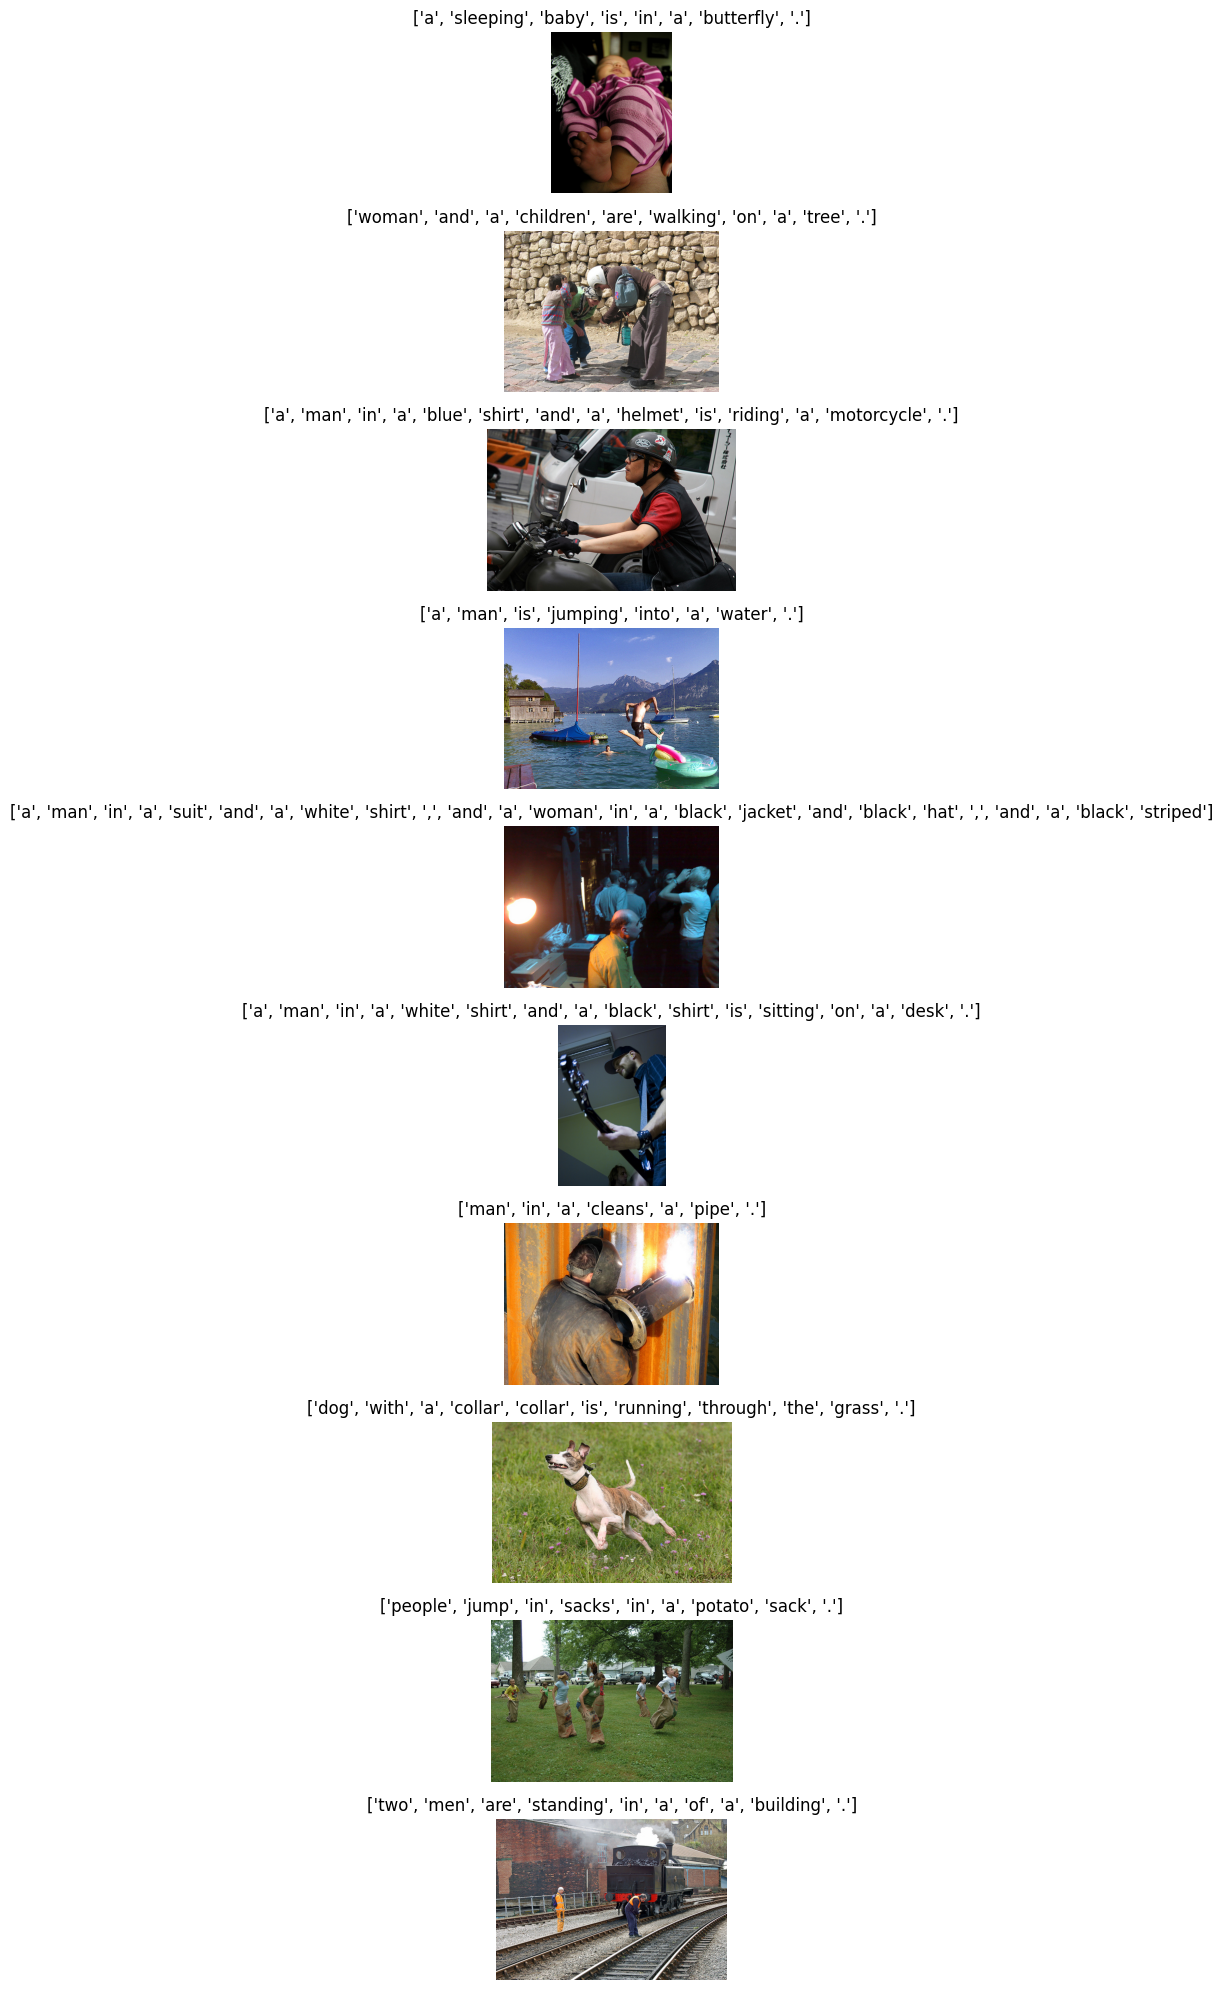

In [76]:
import matplotlib.pyplot as plt
start = 20
num_images = 10  # Number of images you want to display
fig, axes = plt.subplots(num_images, 1, figsize=(10, 20))

for i in range(start, start + num_images):
    image_path = f'/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/{test.iloc[i, 0]}'
    predicted_caption = predict(image_path, img2seq, transform, vocab, sos_token, eos_token, 25, device)
    # Display image and predicted caption
    image = Image.open(image_path)
    axes[i-start].imshow(image)
    axes[i-start].set_title(predicted_caption)
    axes[i-start].axis('off')

plt.tight_layout()
plt.show()